In [1]:
RANDOM_STATE = 42
DEFAULT_IMAGE_1 = '../data/validation/n02088364-beagle/5.jpg'
DEFAULT_IMAGE_2 = '../data/validation/n02111889-Samoyed/2.jpg'

#Dataset params
IMAGE_SIZE = (256, 256)

#SIFT params
COMPUTE_DICTIONNARY = False
COMPUTE_FEATURES_BOW = False
DICTIONNARY_SIZE = 512

In [2]:
import itertools
from keras.utils import np_utils
from glob import glob
import os
from sklearn.datasets import load_files 

#Image 
import numpy as np
import pandas as pd
import progressbar


from PIL import Image
import cv2

#Ploting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline


#Model selection
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#Models
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
   

#Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


### Load datasets

In [7]:
# Fonction for resizing image
desired_size = 256

def resize(img):
    # old_size is in (height, width) format
    old_size = img.shape[:2] 

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    img = cv2.resize(img, (new_size[1], new_size[0]))
    
    # adding black padding when original image is smaller than the dezired size
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    return new_img

In [25]:
def load_images_from_folder(data):
    images = []
    labels = []
    for breed in os.listdir(data):
        label = breed[10:].lower()
        path = data + "/" + breed
        for dogs in os.listdir(path):
            img = cv2.imread(path + "/" + dogs)
            img = resize(img)
            if img is not None:
                images.append(np.array(img))
                labels.append(label)
    images = np.stack(images)
    labels = np.stack(labels)
    return images, labels 

In [26]:
X_train, y_train = load_images_from_folder('../data/train')  
X_valid, y_valid = load_images_from_folder('../data/validation') 
X_test, y_test = load_images_from_folder('../data/test')

In [27]:
#Save the datasets to files
np.save('../data/datasets/' + 'X_train', X_train)
np.save('../data/datasets/' + 'X_valid', X_valid)
np.save('../data/datasets/' + 'y_train', y_train)
np.save('../data/datasets/' + 'y_valid', y_valid)
np.save('../data/datasets/' + 'X_test', X_test)
np.save('../data/datasets/' + 'y_test', y_test)

In [8]:
print(y_train)

['chihuahua' 'chihuahua' 'chihuahua' ... 'african_hunting_dog'
 'african_hunting_dog' 'african_hunting_dog']


In [17]:
ex = X_train[12440]

In [5]:
a = cv2.imread(DEFAULT_IMAGE_1,0)

In [8]:
a =resize(a)

In [18]:
a.shape

(256, 256)

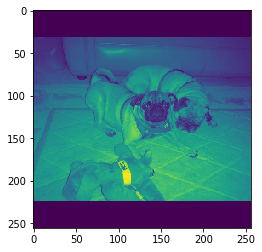

In [18]:
plt.imshow(ex)
plt.show()

In [ ]:
cv2.imshow('img', a)
cv2.waitkey(0)  
  
#closing all open windows  
cv2.destroyAllWindows()  

In [19]:
y_train[12440]

'pug'

# 2. Sift

In [28]:
sift = cv2.xfeatures2d.SIFT_create()

### Example

Here are what our SIFT features look like :


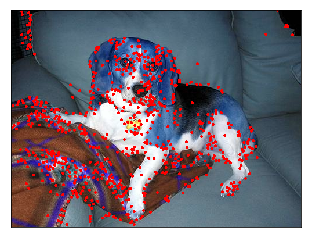

In [22]:
img_example = cv2.imread(DEFAULT_IMAGE_1)
kp, desc = sift.detectAndCompute(img_example, None)

#plt.imshow(cv2.drawKeypoints(img_example, kp, color_img.copy()))
#drawkeypoints doesn't work with WSL

img = img_example.copy()
for marker in kp:
    img = cv2.drawMarker(img, 
                         tuple(int(i) for i in marker.pt),
                         color=(255, 0, 0), markerType=cv2.MARKER_DIAMOND, markerSize=2, thickness=2)
    
print('Here are what our SIFT features look like :')

plt.imshow(img)
plt.xticks([])
plt.yticks([])

plt.show()

In [66]:
ex = X_train[0]

In [69]:
img_yuv = cv2.cvtColor(ex, cv2.COLOR_BGR2YUV)
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
img_equal = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
img_gaussian = cv2.GaussianBlur(img_equal, (9, 9),0)

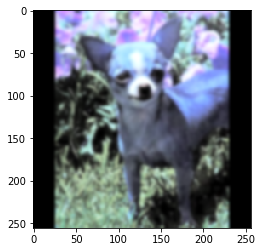

In [71]:
plt.imshow(img_gaussian)
plt.show()

In [72]:
kp, desc = sift.detectAndCompute(img_gaussian, None)

In [74]:
desc.shape

(393, 128)

In [29]:
def build_dictionary(data):
    print('Computing descriptors...')        
    desc_list = []
    bar = progressbar.ProgressBar(maxval=data.shape[0]).start()
                                  
    for idx, img in enumerate(data):
        # histogram equalization
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        img_equal = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        # gaussian filter 
        img_gaussian = cv2.GaussianBlur(img_equal, (9, 9),0)
        
        kp, desc = sift.detectAndCompute(img_gaussian, None)
        desc_list.extend(desc)
        bar.update(idx)
        bar.finish()

    dictionary = MiniBatchKMeans(n_clusters=500, batch_size=200, verbose=0, init_size=3*200)
    dictionary.fit(np.array(desc_list))
  
    return dictionary.cluster_centers_

In [30]:
%time dictionary = build_dictionary(X_train)

100% |########################################################################|


Computing descriptors...


CPU times: user 1h 22min 47s, sys: 1h 39min 43s, total: 3h 2min 30s
Wall time: 27min 25s


In [31]:
#Set Image Descriptor Extractor
bovw_dict = cv2.BOWImgDescriptorExtractor(sift, cv2.BFMatcher(cv2.NORM_L2))
bovw_dict.setVocabulary(dictionary)

In [49]:
type(bovw_dict)

cv2.BOWImgDescriptorExtractor

In [78]:
def feature_extract(img_set, bovw_dict):
    '''Return descriptors of image set'''
    set_features = []
    
    for idx, img in enumerate(img_set):
        if not idx % 1000:
            print('%i images processed' %idx)
        
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        img_equal = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        # gaussian filter 
        img_gaussian = cv2.GaussianBlur(img_equal, (9, 9),0)
        
        features = bovw_dict.compute(img_gaussian, sift.detect(img_gaussian))
        set_features.extend(features)
        
    set_features = np.stack(set_features)
    
    return set_features

In [79]:
#Get train & test image features
train_features = feature_extract(X_train, bovw_dict)
valid_features = feature_extract(X_valid, bovw_dict)
test_feature = feature_extract(X_test, bovw_dict)

0 images processed
1000 images processed
2000 images processed
3000 images processed
4000 images processed
5000 images processed
6000 images processed
7000 images processed
8000 images processed
9000 images processed
10000 images processed
11000 images processed
12000 images processed
13000 images processed
14000 images processed
0 images processed
1000 images processed
2000 images processed
3000 images processed
4000 images processed
0 images processed
1000 images processed


In [77]:
dictionary.shape

(500, 128)

In [75]:
ex = train_features[2]
ex

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00420168, 0.00420168,
       0.00840336, 0.        , 0.00420168, 0.00420168, 0.        ,
       0.00840336, 0.        , 0.00420168, 0.        , 0.        ,
       0.        , 0.        , 0.00840336, 0.        , 0.        ,
       0.01260504, 0.        , 0.        , 0.        , 0.        ,
       0.00840336, 0.00420168, 0.        , 0.00840336, 0.        ,
       0.        , 0.        , 0.        , 0.00420168, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00420168, 0.        , 0.00420168, 0.        , 0.        ,
       0.        , 0.00840336, 0.        , 0.00420168, 0.        ,
       0.        , 0.00420168, 0.00420168, 0.01260504, 0.        ,
       0.        , 0.        , 0.00420168, 0.        , 0.00420168,
       0.00420168, 0.        , 0.        , 0.        , 0.     

In [61]:
ex = ex.transpose

TypeError: unorderable types: builtin_function_or_method() < float()

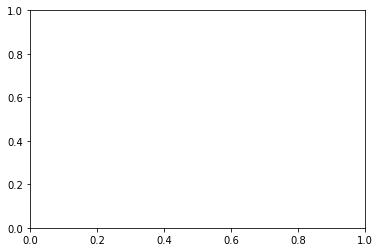

In [62]:
plt.hist(ex)

In [40]:
y_valid

array(['chihuahua', 'chihuahua', 'chihuahua', ..., 'african_hunting_dog',
       'african_hunting_dog', 'african_hunting_dog'], dtype='<U30')

In [80]:
c=[1, 5, 10]
gamma=[1, 0.1, 0.01, 0.0001]

param_grid = [{'C': c, 'gamma': gamma, 'kernel': ['rbf']}]

svc = GridSearchCV(SVC(), param_grid, n_jobs=-1, scoring='accuracy', cv=3, iid=False)
svc.fit(train_features, y_train)

train_score = svc.score(train_features, y_train)
test_score = svc.score(valid_features, y_valid)
print('Train score %0.2f:'%train_score)
print('Test score %0.2f:'%test_score)

print('Best params %s' %str(svc.best_params_))


/home/bayet/.virtualenvs/py3cv4/lib/python3.5/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Train score 0.02:
Test score 0.01:
Best params {'C': 5, 'kernel': 'rbf', 'gamma': 1}


In [81]:
#Get accuracy
y_pred = svc.predict(test_feature)
test_score = accuracy_score(y_test, y_pred)
print('Accuracy for test set: %0.2f' %test_score)

Accuracy for test set: 0.01


In [82]:
y_pred

array(['afghan_hound', 'afghan_hound', 'afghan_hound', ...,
       'afghan_hound', 'afghan_hound', 'afghan_hound'], dtype='<U30')

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, plot_values=False, printed=False,
                          title='Confusion matrix',
                          figsize=(20,20), cmap=plt.cm.Blues, rotation_xticks=45):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    if printed:
        print(cm)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=rotation_xticks)
    plt.yticks(tick_marks, classes)

    if plot_values:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            val = format(cm[i, j], fmt)
            val = int(float(val)) if (float(val) >= 1.) else val
            if float(val):
                plt.text(j, i, val,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [83]:
y_pred

array(['afghan_hound', 'afghan_hound', 'afghan_hound', ...,
       'afghan_hound', 'afghan_hound', 'afghan_hound'], dtype='<U30')

Normalized confusion matrix


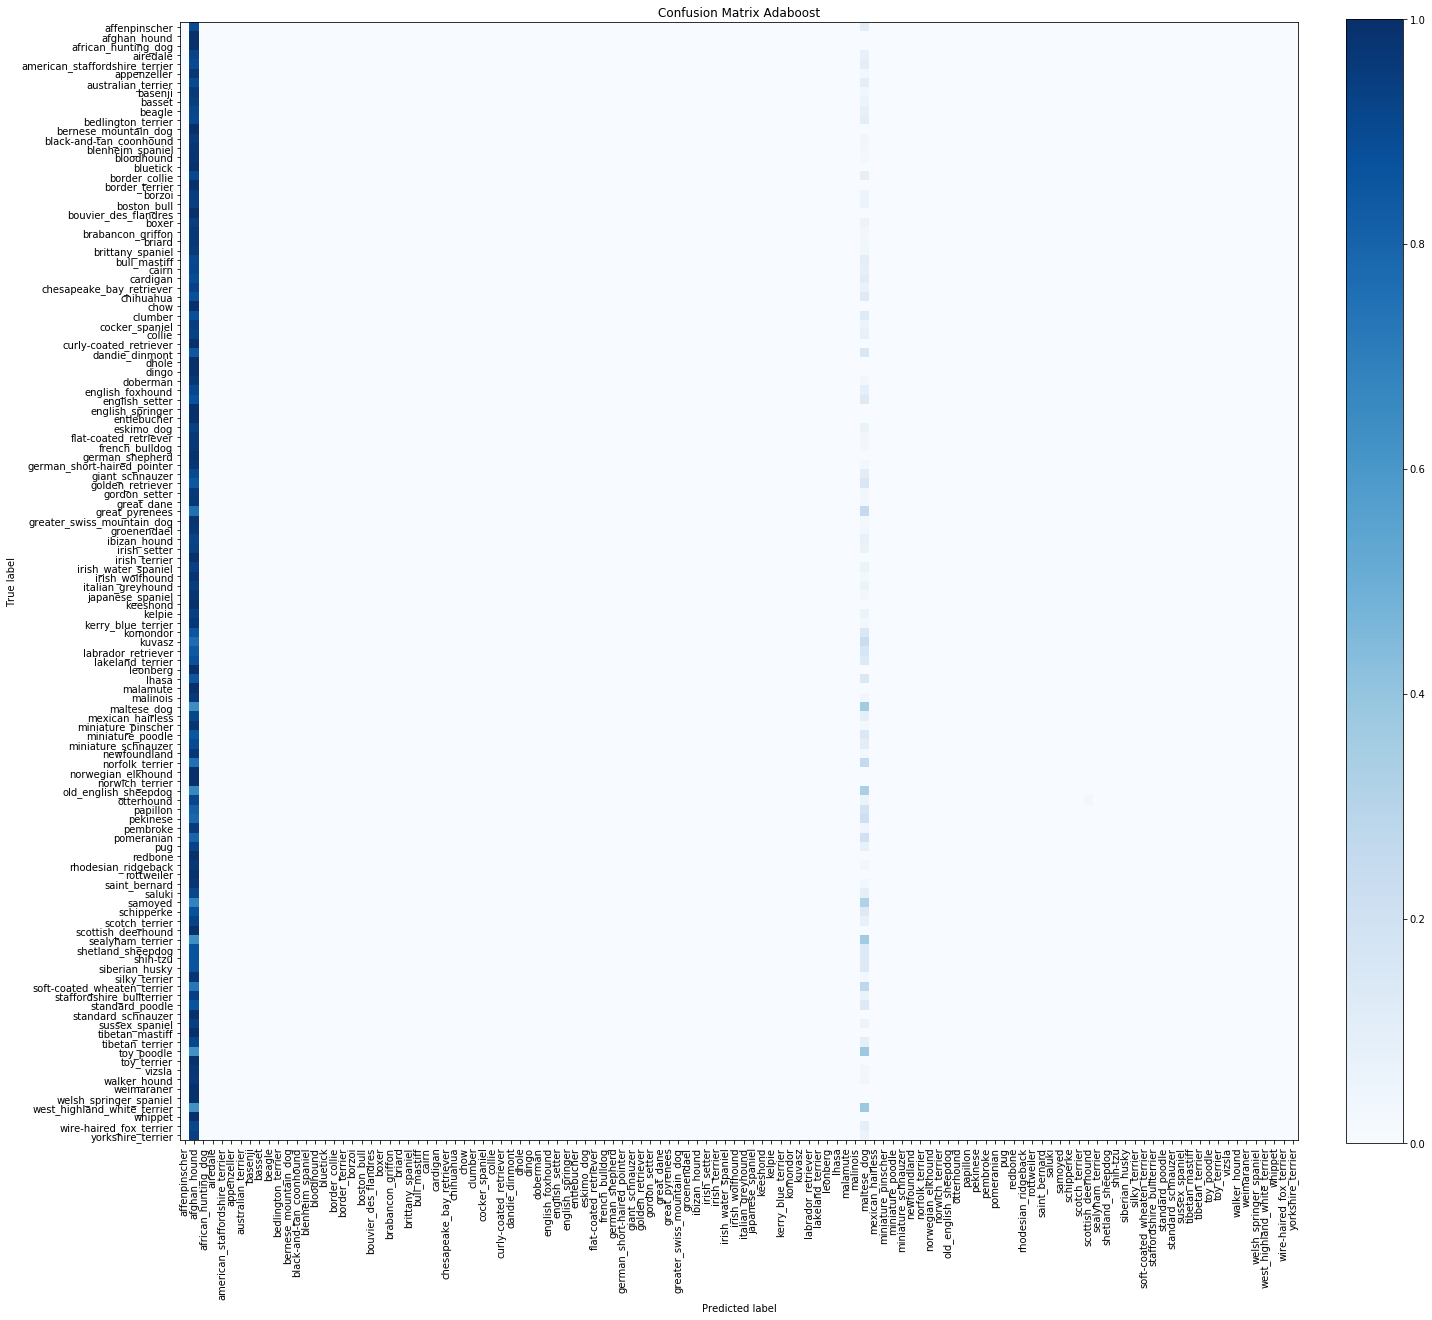

In [39]:
conf_matrix = confusion_matrix(y_valid, y_pred)
plot_confusion_matrix(conf_matrix, classes=np.unique(y_valid), \
                      title='Confusion Matrix svc', normalize=True, rotation_xticks=90)